## Bussiness Problem Statement

In the digital age, the hospitality industry has experienced a significant transformation. 
The rise of online booking platforms has revolutionized how travelers reserve their accommodations,
offering unprecedented convenience and accessibility. 
However, while these platforms have opened up new markets and increased bookings, they also present significant challenges for hotel business owners.


> Problem

The ease of cancellation, while beneficial for customers, presents significant challenges for hotel business owners. From revenue instability and increased operational costs. The owner facing a problem how to reduce the cost related to booking cancellation.


> Goal

Given the disadvantage or cost the booking cancelation, I would like to build a machine learning that capable of predicting the booking that potentially leads to cancellation. by this way we would be able to make prevent or mitigate the disaster cause by the  booking cancellation.

> Analytic Approach

We will analyze pattern of cancellation among features that we have based on previous recorded data with label whether the booking was cancelled or not. we will then build a model that best classify the booking of two possible outcomes.

> Metric Evaluation

In the our problem context, we would focus on recall while sometimes also considering about f2 score. Here’s why:

Recall: If a booking that is likely to be cancelled is missed (false negative), it can lead to empty rooms and lost revenue. High recall ensures that most cancellations are correctly identified, even if it means having more false positives.

F2 Score: This metric gives more weight to recall. It’s particularly useful if the business impact of missed cancellations (false negatives) is significantly higher than the impact of falsely predicted cancellations (false positives). Using the F2 score ensures that the model prioritizes identifying as many cancellations as possible.



<h3 align="left"><font color=royalblue>Dataset Description:</font></h3>

| __Index__ | __Variable__ | __Description__ |
|   :---    |     :---     |       :---      |
| 1 | __is_canceled__ | Reservation cancellation status (0 = not canceled, 1 = canceled) |
| 2 | __country__ | Country of origin of the guest |
| 3 | __market_segment__ | Market segment designation |
| 4 | __previous_cancellations__ | Number of previous bookings that were canceled by the customer |
| 5 | __reserved_room_type__ | Type of reserved room |
| 6 | __booking_changes__ | Number of changes made to the booking |
| 7 | __deposit_type__ | Type of deposit made (No Deposit, Refundable, Non Refund) |
| 8 | __days_in_waiting_list__ | Number of days the booking was in the waiting list |
| 9 | __customer_type__ | Type of customer (Transient, Contract, Transient-Party, Group) |
| 10 | __required_car_parking_spaces__ | Number of car parking spaces required |
| 11 | __total_of_special_requests__ | Number of special requests made |


<a id="import"></a>
# <p style="background-color:white; font-family:calibri; color:black; font-size:150%; text-align:left; border-radius:20px 50px;">Import Libraries</p>

In [1]:
# Import Libraries that will be used in this notebook

## basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# sklearn library
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
# from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.decomposition import PCA


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score, RocCurveDisplay, make_scorer, fbeta_score
from sklearn.metrics._scorer import _SCORERS

import category_encoders as ce


# import dependent function module
from ufunc import *
import shap

import warnings
warnings.filterwarnings('ignore')

<a id="Read dataset"></a>
# <p style="background-color:white; font-family:calibri; color:black; font-size:150%; text-align:left; border-radius:20px 50px;">Read Dataset</p>

In [2]:
df = pd.read_csv("data_hotel_booking_demand.csv")
print(df.shape)
df.head()

(83573, 11)


,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [4]:
df.isna().sum()

country                        351
market_segment                   0
previous_cancellations           0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
reserved_room_type               0
required_car_parking_spaces      0
total_of_special_requests        0
is_canceled                      0
dtype: int64

<a id="EDA"></a>
# <p style="background-color:white; font-family:calibri; color:black; font-size:150%; text-align:left; border-radius:20px 50px;">Exploratory Data Analysis</p>

In [5]:
pd.set_option("display.max_colwidth", None)

pd.DataFrame({
    "feature" : df.columns.values,
    "data_type" : df.dtypes.values,
    "null" : df.isna().mean().values * 100,
    # "negative" : [True if df[i].dtype == int and (df[i] < 0).any() else False for i in df.columns],
    "n_unique" : df.nunique().values,
    # "sample_unique" : [df[i].unique() for i in df.columns]
})

,feature,data_type,null,n_unique
0,country,object,0.419992,162
1,market_segment,object,0.000000,8
2,previous_cancellations,int64,0.000000,15
3,booking_changes,int64,0.000000,19
4,deposit_type,object,0.000000,3
5,days_in_waiting_list,int64,0.000000,115
6,customer_type,object,0.000000,4
7,reserved_room_type,object,0.000000,10
8,required_car_parking_spaces,int64,0.000000,5
9,total_of_special_requests,int64,0.000000,6


>Interpretation:
- We can see above that we have in total 10 Features, and 1 target. among features, five of them are numerical and the rest is categorical
- Only one feature that contains null values, that is country, which contains 351 null values (0.4%)

#### Numerical and Categorical Separation

In [6]:
# numerical and categorical features
cat_columns = [col for col in df.columns if df[col].dtype == "O"]
num_columns = [col for col in df.columns if col not in cat_columns]
cat_columns.remove("country")
num_columns.remove("is_canceled")
print("Numerical columns:\n", num_columns)
print("Categorical Columns:\n", cat_columns)

Numerical columns:
 ['previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']
Categorical Columns:
 ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']


> I would like to drop the country features, due to two reasons, which are:

- High Cardinality, which means that it has contains so much categories (variants), thus have no specific information for the model and should be considered as irrelevant features and should be deleted.
- Considering data ethics, removing the country feature can be a wise decision to avoid potential biases and ensure fairnes

> we don't drop the country feature right now, but in the transformation, we would drop that feature. but, the new question arise, is it the only feature that contain null values?
take a look at the market_segment value.

#### Depth Inspection of market segment feature

In [7]:
df[["market_segment"]].value_counts()

market_segment
Online TA         39460
Offline TA/TO     17025
Groups            13721
Direct             8898
Corporate          3792
Complementary       511
Aviation            165
Undefined             1
Name: count, dtype: int64

In [8]:
df[df["market_segment"] == "Undefined"]

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
70217,PRT,Undefined,0,0,No Deposit,0,Transient-Party,B,0,1,1


> Here we have one cell that countains Undefined, My Interpretation is that this value is the same as the null value. but do getting rid of by dropping it is the best solution?,
My Gut says no. If this undefined value is exist in the data somewhere in the future, we would fail to predict about them.
So That's why I would like to treat it as the null value, that would be replaced by the mode value.

### Checking for Duplicates

In [9]:
# specify columns
cols = ['country','previous_cancellations',
       'booking_changes', 'days_in_waiting_list',
       'customer_type', 'reserved_room_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'market_segment','deposit_type', "is_canceled"]

# check the remainder
len(df) - df.duplicated(subset=cols).sum()

10202

In [10]:
df_clean = df.drop_duplicates(subset=cols, keep='first')

# double check duplicates
df_clean.duplicated().sum()

0

In [11]:
df_clean.shape

(10202, 11)

> we can see that our data contains only 10.202 unique values, where our real data are more than 80.000. but my intuition tell me that it is possible to have unique data happens more than once, so it's unreasonable to drop that duplicate value. I decided not to drop that duplicate value, and delibrately ask our data to put weight on that unique value based on their quantity.

#### Separating Target and Features

In [12]:
# Separating the target from the features
X = df.drop(columns=["is_canceled"], axis=1)
y = df["is_canceled"]
display(X.columns)
print("X shape is :", X.shape)
print("y shape is :", y.shape)


Index(['country', 'market_segment', 'previous_cancellations',
       'booking_changes', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'reserved_room_type', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

X shape is : (83573, 10)
y shape is : (83573,)


#### Look at Proportion of Target Values

In [13]:
# Look at the proportion of target data
y.value_counts(normalize=True)

is_canceled
0    0.631723
1    0.368277
Name: proportion, dtype: float64

> The proportion having a gap, but it's a normal gap.  the canceled proportion is only a half of not

### Outlier Check

In [14]:
# show outliers for numerical column 
lower = []
upper = []
lower_count = []
upper_count = []
outlier_proportion = []

for column in num_columns:
    IQR = X[column].quantile(0.75) - X[column].quantile(0.25)
    lower_bound = X[column].quantile(0.25) - 1.5 * IQR
    upper_bound = X[column].quantile(0.75) + 1.5 * IQR
    lower.append(lower_bound)
    upper.append(upper_bound)
    lower_count.append(len(X[X[column] < lower_bound]))
    upper_count.append(len(X[X[column] > upper_bound]))
    outlier_proportion.append(round((len(X[X[column] < lower_bound]) + len(X[X[column] > upper_bound])) / len(X) * 100, 2))

outliers = pd.DataFrame({
    "Feature" : num_columns,
    "Lower Bound" : lower,
    "Upper Bound" : upper,
    "# Lower" : lower_count,
    "# Upper" : upper_count,
    "% Outlier" : outlier_proportion
})

outliers

,Feature,Lower Bound,Upper Bound,# Lower,# Upper,% Outlier
0,previous_cancellations,0.0,0.0,0,4513,5.40
1,booking_changes,0.0,0.0,0,12700,15.20
2,days_in_waiting_list,0.0,0.0,0,2585,3.09
3,required_car_parking_spaces,0.0,0.0,0,5227,6.25
4,total_of_special_requests,-1.5,2.5,0,2051,2.45


> as we can see, most of our data boundary are in zero for upper and lower (except total_of_special_request), and all the data outside it perceived as outliers, this is so strange, but we have to deal with it.

### Data Distribution Check

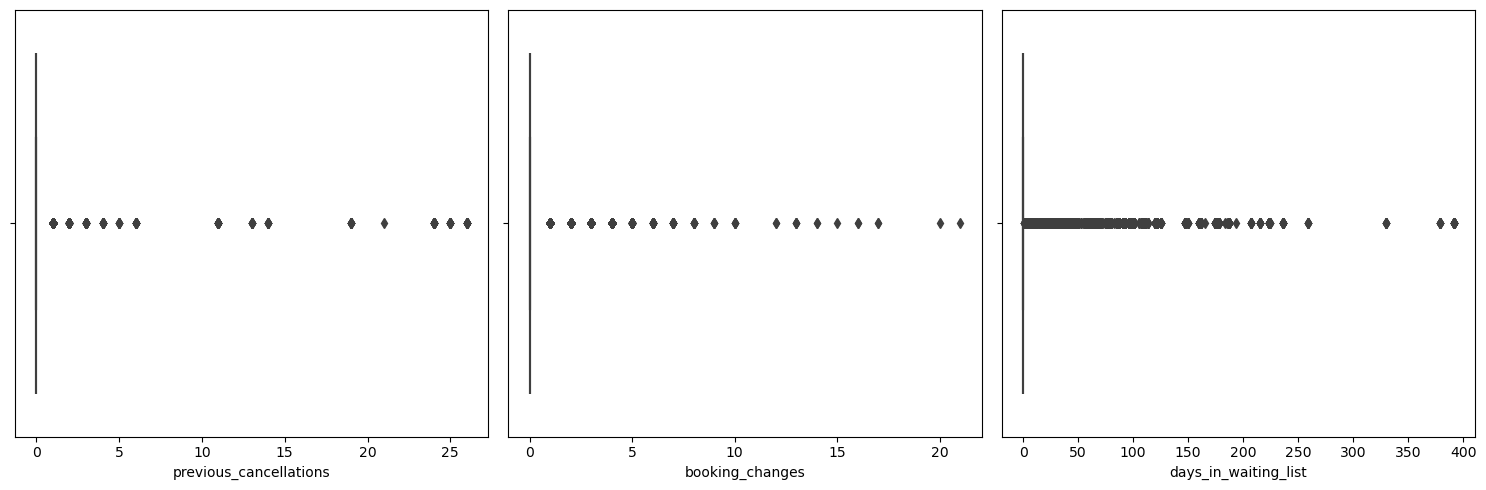

In [16]:
# check for the data distribution for numerical columns

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, column in enumerate(num_columns):
    if i >= 3:
        continue
    sns.boxplot(x= X[column], orient="horizontal", ax=ax[i])
    plt.xlabel(column)

plt.tight_layout()
plt.show()

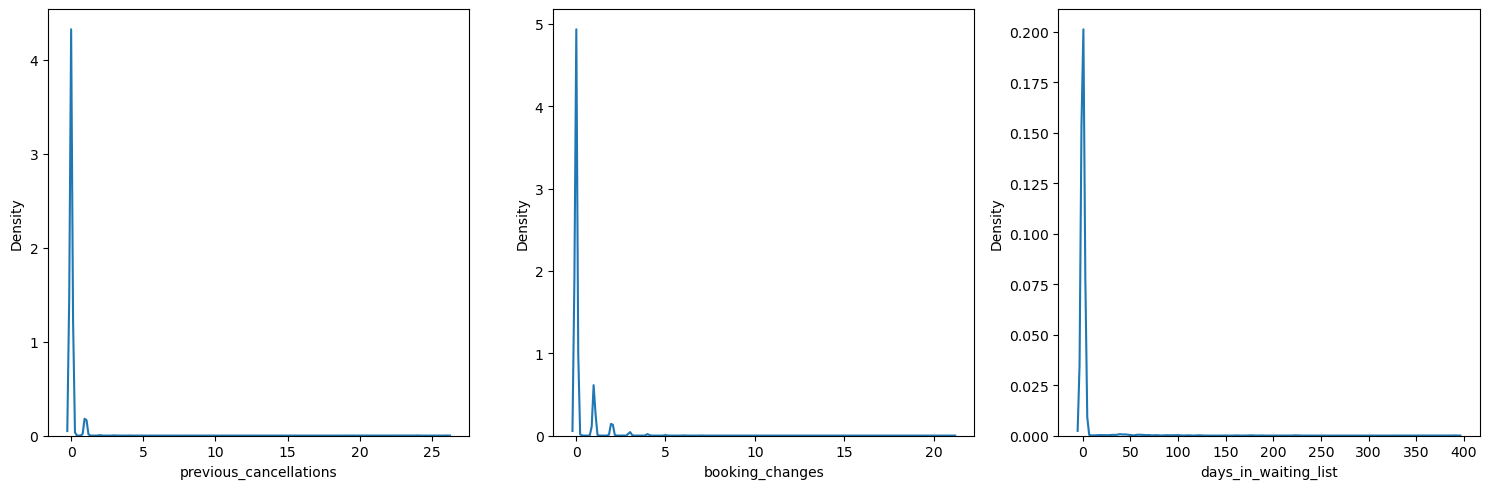

In [18]:
# check for the KDE Plot for numerical columns

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, column in enumerate(num_columns):
    if i >= 3:
        continue
    sns.kdeplot(x= X[column], ax=ax[i])
    plt.xlabel(column)

plt.tight_layout()
plt.show()

>- from the above graphic we can see that our numberical features are very right skew, and it's skewness is very extreme. Treatment should be perform on this data distribution in order to decrease the skewness.
>- We only show 3 out of 5 numerical features, but almost all of them are have very similar characteristics.

In [19]:
# Log is one  of the solution we can do to decrease the skewness, altough in our case, due to the the abundant of 0 values. it's unlikely to fully solve the problem of skewness,
# but this solution is good enough to decrease the skewness, which is helpful for us when build model for KNN, and Logistic Regression.
# while for Tree Family, this log scale treatment has no effect

def log_prep(df, columns):
    df_news = df.copy()
    for column in columns:
        df_news[column] = np.log(df_news[column] + 1)  # using log natural with e, this easier to interpret in percent increase
        # df_news[column] = np.log10(df_news[column] + 1)   # using log 10
    return df_news

X_new = log_prep(X, num_columns)

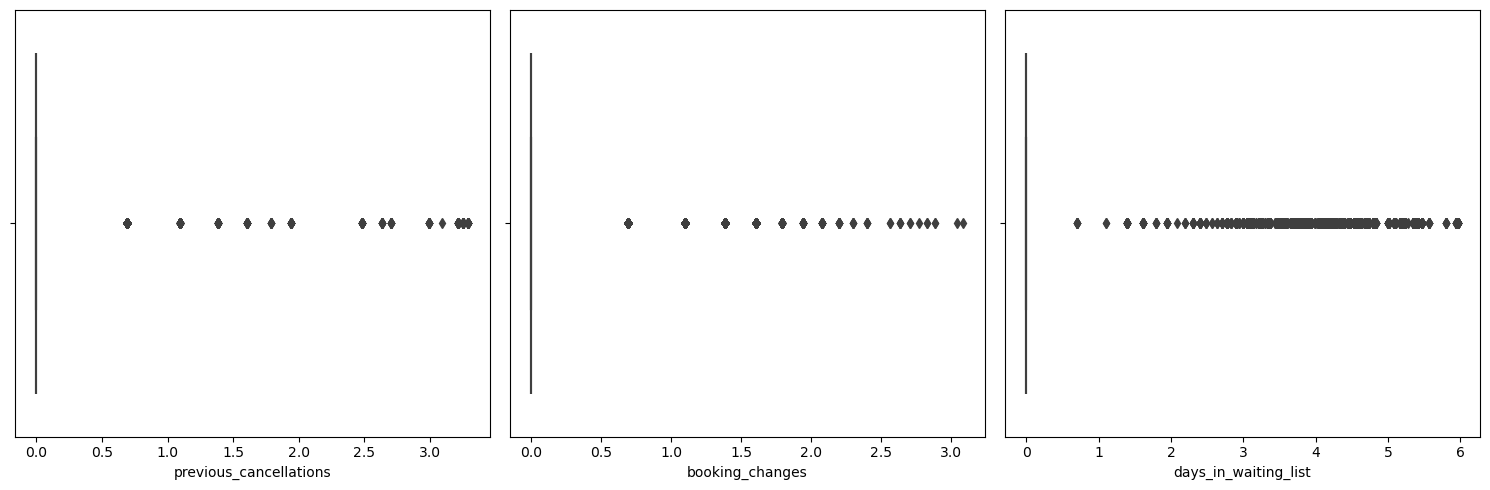

In [20]:
# check for the data distribution for numerical columns

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, column in enumerate(num_columns):
    if i >= 3:
        continue
    sns.boxplot(x= X_new[column], orient="horizontal", ax=ax[i])
    plt.xlabel(column)

plt.tight_layout()
plt.show()

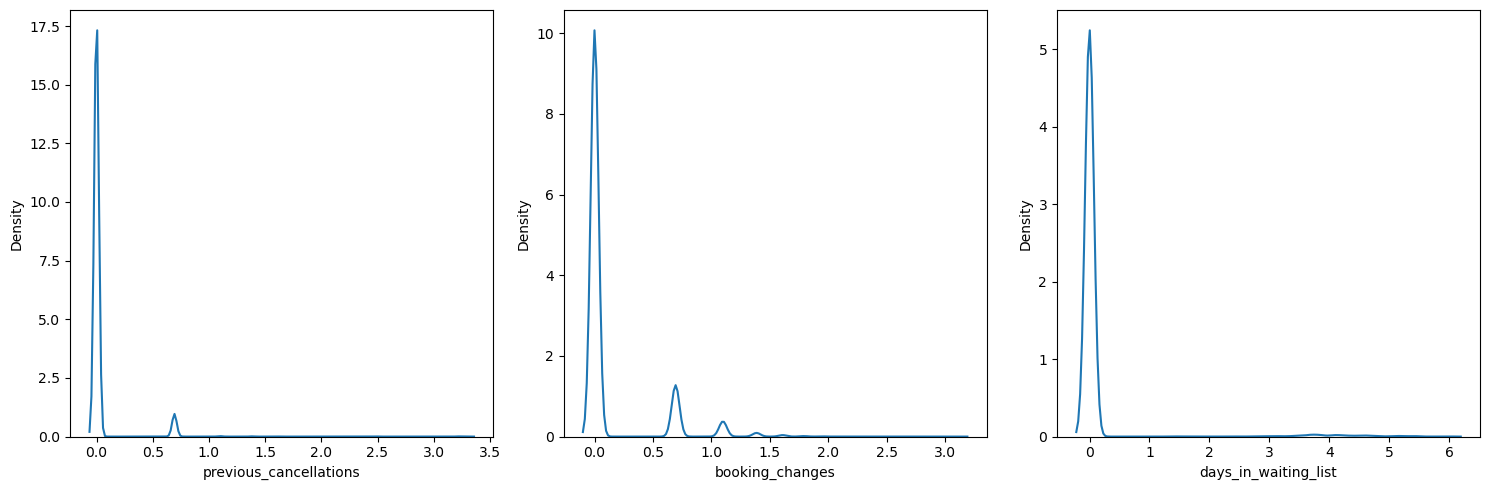

In [21]:
# check for the KDE Plot for numerical columns

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, column in enumerate(num_columns):
    if i >= 3:
        continue
    sns.kdeplot(x= X_new[column], ax=ax[i])
    plt.xlabel(column)

plt.tight_layout()
plt.show()

>- We only show 3 out of 5 Numerical Features, but almost all of our numerical features are the same characteristic as shown above
>- As we manipulate the data, we can see that the distribution changes, even though the distribution is not normal yet, but we success to reduce the skewness. we should see whether this treatment give effect on our model later on.

#### Separating ordinal and nominal categorical features

In [22]:
# We would like to separate ordinal from nominal categorical features
one_hot_columns = cat_columns.copy()
one_hot_columns.remove("reserved_room_type")
one_hot_columns.remove("market_segment")
print("Nominal Features :", one_hot_columns)

Nominal Features : ['deposit_type', 'customer_type']


In [23]:
bin_columns = ["market_segment"]
ordinal_columns = ["reserved_room_type"]
print("Binary Features :", bin_columns)
print("Ordinal Features :", ordinal_columns)

Binary Features : ['market_segment']
Ordinal Features : ['reserved_room_type']


<a id="data splitting"></a>
# <p style="background-color:white; font-family:calibri; color:black; font-size:150%; text-align:left; border-radius:20px 50px;">Split the Dataset</p>

In [24]:
### Train & Test Splitting

X_train, X_test, y_train, y_test = train_test_split(X_new, y, stratify=y, test_size=0.2, random_state=0)

<a id="transformer"></a>
# <p style="background-color:white; font-family:calibri; color:black; font-size:150%; text-align:left; border-radius:20px 50px;">Transformer Instances</p>

In [25]:

ordinal_order = [["A", "B", "C", "D", "E", "F", "G", "H", "L", "P"]]

# transformer with log_prep
transformer1 = ColumnTransformer([
    ("num", LogTransformer(columns=num_columns), num_columns),
    ("nominal", OneHotEncoder(drop="first"), one_hot_columns),
    ("binary", Pipeline([('imputer', ModeImputer(column='market_segment', missing_value='Undefined')),
                          ("binary" , ce.BinaryEncoder())]), bin_columns),
    ("ordinal", OrdinalEncoder(categories=ordinal_order), ordinal_columns),
    # ("normalize", RobustScaler(), num_columns),
], remainder="drop"
)

# transformer without log_prep but with scaling
transformer2 = ColumnTransformer([
    ("nominal", OneHotEncoder(drop="first"), one_hot_columns),
    ("binary", Pipeline([('imputer', ModeImputer(column='market_segment', missing_value='Undefined')),
                          ("binary" , ce.BinaryEncoder())]), bin_columns),
    ("ordinal", OrdinalEncoder(categories=ordinal_order), ordinal_columns),
    # ("passthrough", "passthrough", num_columns),
    ("normalize", MinMaxScaler(), num_columns),
    # ("normalize", RobustScaler(), num_columns),
    # ("normalize", StandardScaler(), num_columns),
], remainder="drop"
)

# transformer without log_prep and scaling
transformer3 = ColumnTransformer([
    ("nominal", OneHotEncoder(drop="first"), one_hot_columns),
    ("binary", Pipeline([('imputer', ModeImputer(column='market_segment', missing_value='Undefined')),
                          ("binary" , ce.BinaryEncoder())]), bin_columns),
    ("ordinal", OrdinalEncoder(categories=ordinal_order), ordinal_columns),
    ("passthrough", "passthrough", num_columns),
    # ("normalize", MinMaxScaler(), num_columns),
    # ("normalize", RobustScaler(), num_columns),
    # ("normalize", StandardScaler(), num_columns),
], remainder="drop"
)

<a id="PCA"></a>
# <p style="background-color:white; font-family:calibri; color:black; font-size:150%; text-align:left; border-radius:20px 50px;">Principal Component Analysis</p>

pca section is intended to see whether we can compress our dimension into 3 dimensions, so that we can easily visualize the spread of the data with their labels.

Visualization might be important because it might give us clue of what kind of feature engineering or modeling algorithm, that might be effective.

But it's very important to note that we can rely on PCA whenever information loss is  still allowable, means that our data retention from PCA still are repesentative of the real one.


In [30]:
# PCA transformation
pca_x = transformer1.fit_transform(X)

# create K component
pca = PCA(n_components=14)
pca.fit(pca_x)

# transform the data
X_pca = pca.transform(pca_x)
X_pca

array([[-1.12313395e+00,  5.37841220e-01, -9.20028909e-01, ...,
        -9.45058055e-02,  4.43585475e-03, -2.52818100e-03],
       [-8.49182895e-01, -8.28744292e-01,  5.87745233e-01, ...,
        -2.83447397e-02,  3.83727416e-03,  6.13503882e-04],
       [-8.42563596e-01, -8.22122663e-01,  5.56649719e-01, ...,
        -2.00779592e-02,  2.08130939e-03, -1.03947499e-03],
       ...,
       [ 2.12896803e+00, -4.62420737e-01,  4.03696682e-01, ...,
        -3.68806196e-02,  3.56654064e-03, -5.54889119e-04],
       [-1.12313395e+00,  5.37841220e-01, -9.20028909e-01, ...,
        -9.45058055e-02,  4.43585475e-03, -2.52818100e-03],
       [-1.10938479e+00,  1.86243176e-01, -2.53976395e-01, ...,
         1.88165968e-02,  3.54095251e-03, -2.02723471e-03]])

In [31]:
X_pca.shape

(83573, 14)

In [32]:
# evaluate the information
variance = []

for i in range(0, 14):
    variance.append(np.var(X_pca[:,i]))

variance

[2.945341261876395,
 0.5811849891367893,
 0.4142882733922261,
 0.2693191273892806,
 0.2380190523887889,
 0.12938210646632003,
 0.10214569280520168,
 0.057351691485660314,
 0.03901769018724423,
 0.03261157578312119,
 0.0260894788994706,
 0.0185107911455869,
 0.004203235837596219,
 0.0013045028740600712]

In [33]:
print("information extracted: {}".format((np.sum(variance[:3])*100)/np.sum(variance)))

information extracted: 81.10725460442345


> We can see that information extracted is about 81 percent. this is good enough for us to continue using PCA for visualize our data so can have better understanding of it. Let's Visualize

In [34]:
# PCA transformation
pca_x = transformer1.fit_transform(X)

# create K component
pca = PCA(n_components=3)
pca.fit(pca_x)

# transform the data
X_pca = pca.transform(pca_x)


Color mapping: {0: (0.03124934374934376, 1.0, 1.3125013124790507e-06), 1: (0.0, 0.062501968751969, 1.0)}


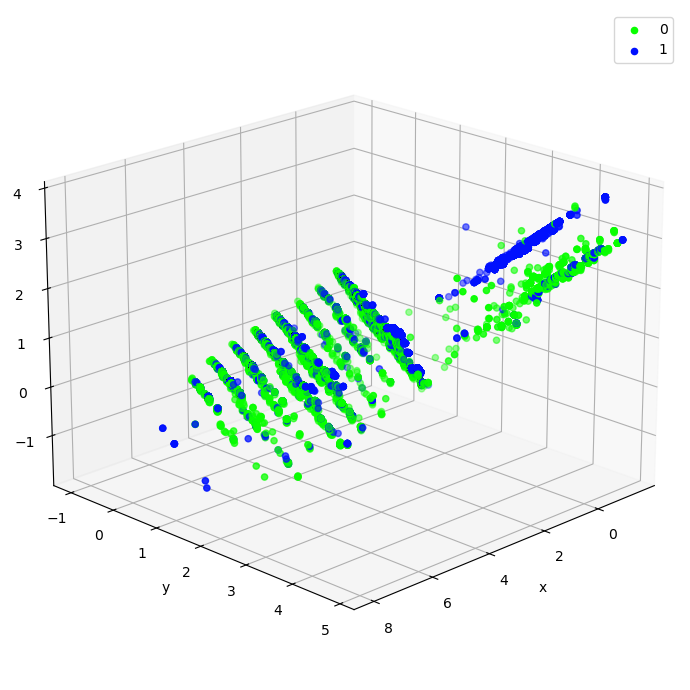

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Assuming X_new is your DataFrame and num_columns contains at least three numerical columns
# Also assuming `hue_column` is the categorical column based on which colors are assigned
hue = [0,1] # replace with your categorical column name

# Define a color palette for the hue
palette = sns.color_palette("hsv", len(hue))
colors = y.apply(lambda x: palette[hue.index(x)])

# Map each unique hue to a color
color_mapping = {hue: palette[i] for i, hue in enumerate(hue)}
print("Color mapping:", color_mapping)  # Print out the mapping for reference

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Extracting the first three numerical columns
x = X_pca[:, 0]
y_axis = X_pca[:, 1]
z = X_pca[:, 2]

# Creating the 3D scatter plot
sc = ax.scatter(x, y_axis, z, c=colors, marker='o')

# Setting the labels
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# # Create a legend
# handles, labels = sc.legend_elements()
# legend_labels = hue
# ax.legend(handles, legend_labels)

for label in hue:
    ax.scatter([], [], [], color=color_mapping[label], label=label)
ax.legend()

ax.view_init(elev=20, azim=45)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)  # Adjust margins as needed
plt.tight_layout()
plt.show()

<a id="model Benchmarking"></a>
# <p style="background-color:white; font-family:calibri; color:black; font-size:150%; text-align:left; border-radius:20px 50px;">Model Benchmarking</p>

In [36]:
# from sklearn.svm import SVC

knn = KNeighborsClassifier()
logreg = LogisticRegression()
dtree = DecisionTreeClassifier()
forest = RandomForestClassifier()

ada = AdaBoostClassifier(dtree, n_estimators= 200,
                           learning_rate= 0.1, random_state=10)

gbc = GradientBoostingClassifier(n_estimators= 200,
                           learning_rate= 0.1, random_state=10)

xgb = XGBClassifier(n_estimators= 200,
                           learning_rate= 0.1, random_state=10)


# f2 score
f2 = make_scorer(fbeta_score, beta=2)

In [37]:
def model_benchmarking(log_prep=False):
    # model after being logged
    models = [knn, logreg, dtree, forest, xgb]

    # define an evaluation metric

    recall_mean = []
    recall_std = []
    f2_mean = []
    f2_std = []
    # accuracy_mean = []
    # accuracy_std = []

    model_name = []
    scoring = {"recall" : "recall",
            "f2": f2,
            #"accuracy" : "accuracy"
        }

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # find the model score

    for model in models:

        if log_prep:
            model_pipeline = Pipeline([
                ("preprocessing", transformer1),
                ("modeling", model)
            ])
        else:
            model_pipeline = Pipeline([
                ("preprocessing", transformer2),
                ("modeling", model)
            ])

        # fitting via cross_val_score

        model_cv = cross_validate(
            model_pipeline,
            X_train,
            y_train,
            cv=kfold,
            scoring = scoring,
            error_score="raise",
        )

        ## evaluate
        recall_mean.append(model_cv["test_recall"].mean())
        recall_std.append(model_cv["test_recall"].std())
        f2_mean.append(model_cv["test_f2"].mean())
        f2_std.append(model_cv["test_f2"].std())
        # accuracy_mean.append(model_cv["test_accuracy"].mean())
        # accuracy_std.append(model_cv["test_accuracy"].std())

        model_name.append(model.__class__.__name__)

    cv_result = pd.DataFrame({
        "model" : model_name,
        "recall_mean" : recall_mean,
        "recall_std" : recall_std,
        "f2_mean" : f2_mean,
        "f2_std" : f2_std,
        # "accuracy_mean" : accuracy_mean,
        # "accuracy_std" : accuracy_std
    }).sort_values(by="recall_mean", ascending=False)

    return cv_result

In [38]:
# model benchmarking without log_prep
cv_result = model_benchmarking()
cv_result

,model,recall_mean,recall_std,f2_mean,f2_std
3,RandomForestClassifier,0.622574,0.008312,0.651075,0.007351
2,DecisionTreeClassifier,0.621355,0.007745,0.649996,0.006816
4,XGBClassifier,0.614817,0.009062,0.645051,0.007840
1,LogisticRegression,0.606613,0.009065,0.636697,0.008278
0,KNeighborsClassifier,0.503292,0.059937,0.546585,0.051449


In [39]:
# model benchmarking with log_prep
cv_result = model_benchmarking(log_prep=True)
cv_result

,model,recall_mean,recall_std,f2_mean,f2_std
3,RandomForestClassifier,0.622533,0.007904,0.650984,0.006954
2,DecisionTreeClassifier,0.621315,0.007794,0.649948,0.006846
4,XGBClassifier,0.614735,0.009097,0.645020,0.007855
1,LogisticRegression,0.607872,0.008993,0.637910,0.008151
0,KNeighborsClassifier,0.521650,0.065986,0.559574,0.054364


- as we can see that Random Forest are the best in this benchmarking slightly better (we cannot know for sure), but compare to decision tree in term of f2 score, random forest then decided to be the best in this benchmarking
- we can see that our log_prep influence so little in logistic regression, even smaller at other models
- but decision tree are competing with very slight difference compare to random forest, we need to also consider that
- for future hyperparameter tuning, decision tree should be included
- so that's why I would like to include Random Forest, and decision tree in the hyperparameter tuning phase
- in the hyperparameter tuning phase, we don't include any scaling on the numerical features, because our choosen model are tree family, where scaling have no effect.

<a id="hyperparameter tuning"></a>
# <p style="background-color:white; font-family:calibri; color:black; font-size:150%; text-align:left; border-radius:20px 50px;">Hyperparameter Tuning</p>

In [40]:
def hyperparameter_tuning(hyperparam_space, model, cv_method="stratify", scoring="recall", brute=True, log_prep=True):
    if log_prep:
        estimator = Pipeline([
            ("preprocessing", transformer1),
            ("modeling", model)
        ])
    else:
        estimator = Pipeline([
            ("preprocessing", transformer3),
            ("modeling", model)
        ])
    if cv_method == "stratify":
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    else:
        kfold = KFold(n_splits=5, shuffle=True, random_state=0)

    if brute:
        search_result = GridSearchCV(
                            estimator=estimator,
                            param_grid =hyperparam_space,
                            cv= kfold,
                            scoring=scoring,
                            n_jobs=-1
                            )
        
    else:
        search_result = RandomizedSearchCV(
                            estimator=estimator,
                            param_distributions = hyperparam_space,
                            cv= kfold,
                            scoring=scoring,
                            n_jobs=-1
                            )
    return search_result

### Random Forest

In [120]:
# Define parameter grids
param_grids ={
        'modeling__n_estimators': [100, 125, 150, 175],
        'modeling__criterion': ['entropy'],
        'modeling__max_depth': [10, 15, 20, None],
        'modeling__min_samples_split': [2, 3, 4, 5],
        'modeling__min_samples_leaf': [2, 3],
        'modeling__class_weight': ['balanced'] + [{0: 1, 1: 3}]
}

In [121]:
gridsearch_rf_grid = hyperparameter_tuning(param_grids, forest, brute=True)
gridsearch_rf_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         LogTransformer(columns=['previous_cancellations',
                                                                                                 'booking_changes',
                                                                                                 'days_in_waiting_list',
                                                                                                 'required_car_parking_spaces',
                                                                                                 'total_of_special_requests']),
                                                                         ['previous_cancellations',
                                                                          'booking_changes',
                                                                          'd...
                                                                                                     'P']]),
                                                                         ['reserved_room_type'])])),
                                       ('modeling', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'modeling__class_weight': ['balanced', {0: 1, 1: 3}],
                         'modeling__criterion': ['entropy'],
                         'modeling__max_depth': [10, 15, 20, None],
                         'modeling__min_samples_leaf': [2, 3],
                         'modeling__min_samples_split': [2, 3, 4, 5],
                         'modeling__n_estimators': [100, 125, 150, 175]},
             scoring='recall')

In [122]:
print('Random Forest')
print('Best_score:', gridsearch_rf_grid.best_score_)
print('Best_params:', gridsearch_rf_grid.best_params_)

Random Forest
Best_score: 0.8912355849521869
Best_params: {'modeling__class_weight': {0: 1, 1: 3}, 'modeling__criterion': 'entropy', 'modeling__max_depth': 10, 'modeling__min_samples_leaf': 3, 'modeling__min_samples_split': 3, 'modeling__n_estimators': 125}


> Random Forest
- Best_score: 0.8912355849521869
- Best_params: {'modeling__class_weight': {0: 1, 1: 3}, 'modeling__criterion': 'entropy', 'modeling__max_depth': 10, 'modeling__min_samples_leaf': 3, 'modeling__min_samples_split': 3, 'modeling__n_estimators': 125}

#### Decision Tree

In [117]:
param_grids_dtree = {
    'modeling__criterion': ['gini', 'entropy'],
    'modeling__max_depth': [13, 14, 15],
    'modeling__min_samples_split': [2, 3, 4],
    'modeling__min_samples_leaf': [1, 2, 3],
    'modeling__class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

In [118]:
# grid search

gridsearch_dtree = hyperparameter_tuning(param_grids_dtree, dtree, brute=True)
gridsearch_dtree.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         LogTransformer(columns=['previous_cancellations',
                                                                                                 'booking_changes',
                                                                                                 'days_in_waiting_list',
                                                                                                 'required_car_parking_spaces',
                                                                                                 'total_of_special_requests']),
                                                                         ['previous_cancellations',
                                                                          'booking_changes',
                                                                          'd...
                                                                                                     'B',
                                                                                                     'C',
                                                                                                     'D',
                                                                                                     'E',
                                                                                                     'F',
                                                                                                     'G',
                                                                                                     'H',
                                                                                                     'L',
                                                                                                     'P']]),
                                                                         ['reserved_room_type'])])),
                                       ('modeling', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'modeling__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                                    {0: 1, 1: 3}],
                         'modeling__criterion': ['gini', 'entropy'],
                         'modeling__max_depth': [13, 14, 15],
                         'modeling__min_samples_leaf': [1, 2, 3],
                         'modeling__min_samples_split': [2, 3, 4]},
             scoring='recall')

In [119]:
print('Decision Tree')
print('Best_score:', gridsearch_dtree.best_score_)
print('Best_params:', gridsearch_dtree.best_params_)

Decision Tree
Best_score: 0.8844125076801908
Best_params: {'modeling__class_weight': {0: 1, 1: 3}, 'modeling__criterion': 'entropy', 'modeling__max_depth': 13, 'modeling__min_samples_leaf': 2, 'modeling__min_samples_split': 3}


> Decision Tree
- Best_score: 0.8844125076801908
- Best_params: {'modeling__class_weight': {0: 1, 1: 3}, 'modeling__criterion': 'entropy', 'modeling__max_depth': 13, 'modeling__min_samples_leaf': 2, 'modeling__min_samples_split': 3}

## Decision

> Because random forest has so better performance after tuning compare to decision tree, we then decide that our best algorithm is using random forest, with hyperparameter as specified before.

#### Finding best treshold using best model

In [41]:
### Retraining using best Parameter, and Selecting the best treshold to be used
#predict probibility

model = RandomForestClassifier(n_estimators=125,
                                    min_samples_split=3,
                                    min_samples_leaf=3,
                                    max_depth=10,
                                    criterion="entropy",
                                    class_weight={0 : 1, 1: 3},
                                    random_state=0
)


model_pipeline = Pipeline([
        ("preprocessing", transformer3),
        ("modeling", model)
    ])



model_pipeline.fit(X_train, y_train)

y_prob = model_pipeline.predict_proba(X_train)
y_prob = y_prob[:,1]


# threshold

threshold_value = [i/100 for i in range(20,80)]

score_list = []
score = 0

for i in threshold_value:

    # predict
    y_pred = np.where(y_prob>i,1,0)

    score_temp = fbeta_score(y_train,y_pred, beta=2)
    score_list.append(score_temp)

    if score_temp > score:
        score = score_temp
        best_score = score
        best_threshold = i
print('best f2 score :', best_score)
print('best threshold : ', best_threshold)

# check for recall
y_pred = np.where(y_prob>best_threshold, 1, 0)
score = recall_score(y_train, y_pred)
print("recall_score :", score)
print(classification_report(y_train, y_pred))

best f2 score : 0.7953637640836342
best threshold :  0.39
recall_score : 0.9381041345138494
              precision    recall  f1-score   support

           0       0.92      0.44      0.60     42236
           1       0.49      0.94      0.65     24622

    accuracy                           0.62     66858
   macro avg       0.71      0.69      0.62     66858
weighted avg       0.77      0.62      0.62     66858



In [42]:
# Apply on Test Data
y_test_proba = model_pipeline.predict_proba(X_test)[:, 1]
y_test_pred = np.where(y_test_proba > best_threshold, 1, 0)
rec_score = recall_score(y_test, y_test_pred)
f2_score = fbeta_score(y_test, y_test_pred, beta=2)
print("f2 score :", f2_score)
print("recall_score :", rec_score)
print(classification_report(y_test, y_test_pred))

f2 score : 0.79386726175717
recall_score : 0.9361598440545809
              precision    recall  f1-score   support

           0       0.92      0.44      0.60     10559
           1       0.49      0.94      0.65      6156

    accuracy                           0.62     16715
   macro avg       0.71      0.69      0.62     16715
weighted avg       0.76      0.62      0.61     16715



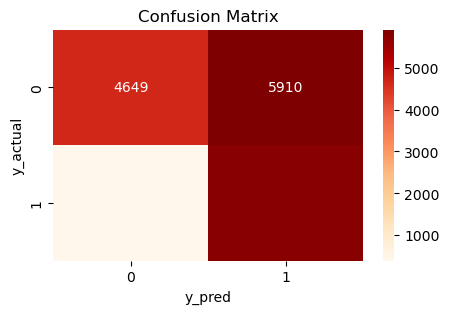

In [66]:
plt.figure(figsize=(5, 3))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd')
plt.xlabel("y_pred")
plt.ylabel("y_actual")
plt.title("Confusion Matrix")
plt.show()

In [44]:
confusion_matrix(y_test, y_test_pred)

array([[4649, 5910],
       [ 393, 5763]], dtype=int64)

### Feature Importances

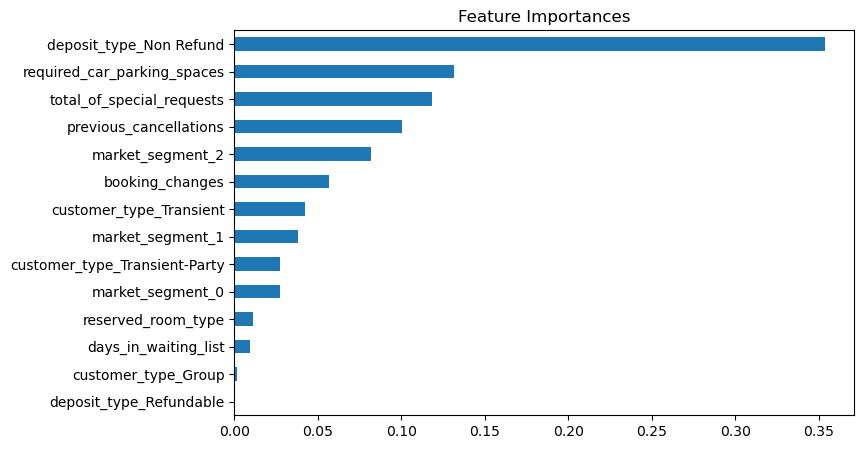

In [53]:
rf = model_pipeline.named_steps["modeling"]

feature_imp = pd.Series(rf.feature_importances_, transformer3.get_feature_names_out()).sort_values(ascending = True)
feature_imp

list_features = []
for feature in feature_imp.index:
    list_features.append('_'.join(feature.split('_')[2:]))
list_features

feature_imp.index = list_features
feature_imp

plt.figure(figsize=(8,5))
feature_imp.plot(kind='barh', title='Feature Importances')
plt.show()

<a id="dump"></a>
# <p style="background-color:white; font-family:calibri; color:black; font-size:150%; text-align:left; border-radius:20px 50px;">Model Dump</p>

In [46]:
## before dump the model, let's train the model for the last time using all the data we have before

model = RandomForestClassifier(n_estimators=125,
                                    min_samples_split=3,
                                    min_samples_leaf=2,
                                    max_depth=10,
                                    criterion="entropy",
                                    class_weight={0 : 1, 1: 3},
                                    random_state=0
)


model_pipeline = Pipeline([
        ("preprocessing", transformer3),
        ("modeling", model)
    ])


model_final = model_pipeline
model_final.fit(X, y)

# Save the model
import pickle

pickle.dump(model_final, open("models/model.pkl", "wb"))

<a id="XAI"></a>
# <p style="background-color:white; font-family:calibri; color:black; font-size:150%; text-align:left; border-radius:20px 50px;">Explainable AI</p>

In [55]:
explainer = shap.Explainer(
    model_final[1].predict,
    model_final[0].transform(X_test)
)

X_test_preprocessed = model_final[0].transform(X_test)
features = model_final[0].get_feature_names_out()

list_features = []
for feature in features:
    list_features.append('_'.join(feature.split('_')[2:]))
list_features

X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=list_features)

shap_values = explainer(X_test_preprocessed)

Permutation explainer: 16716it [1:23:52,  3.32it/s]                             


In [56]:
i = 10
X_test.iloc[i],y_test.iloc[i]

(country                               ITA
 market_segment                  Online TA
 previous_cancellations                0.0
 booking_changes                       0.0
 deposit_type                   No Deposit
 days_in_waiting_list                  0.0
 customer_type                   Transient
 reserved_room_type                      A
 required_car_parking_spaces           0.0
 total_of_special_requests             0.0
 Name: 68519, dtype: object,
 0)

#### Local Interpretation of Random Forest for certain instances

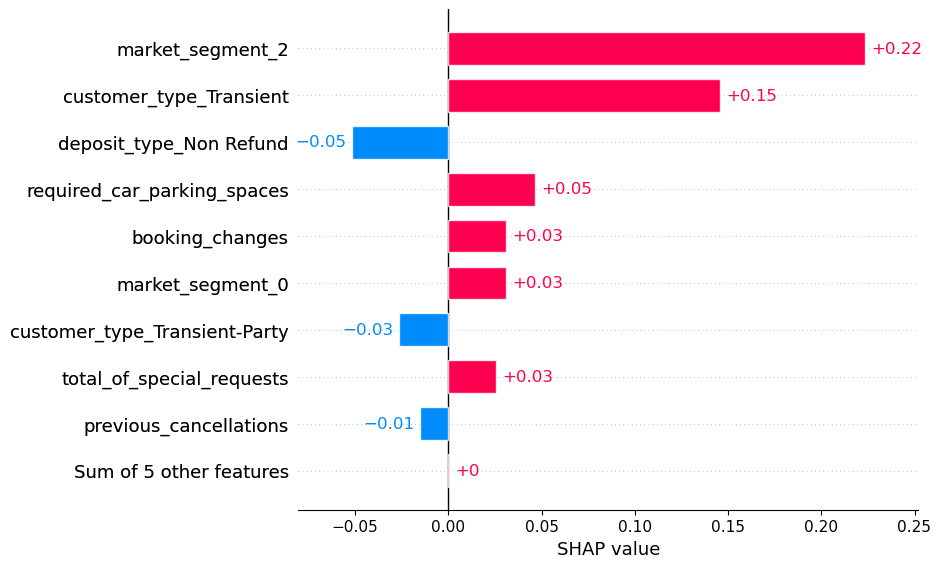

In [57]:
# shap_values for explain observation in test
shap.plots.bar(shap_values[i])

In [67]:
#### Global Interpretation of Random Forest

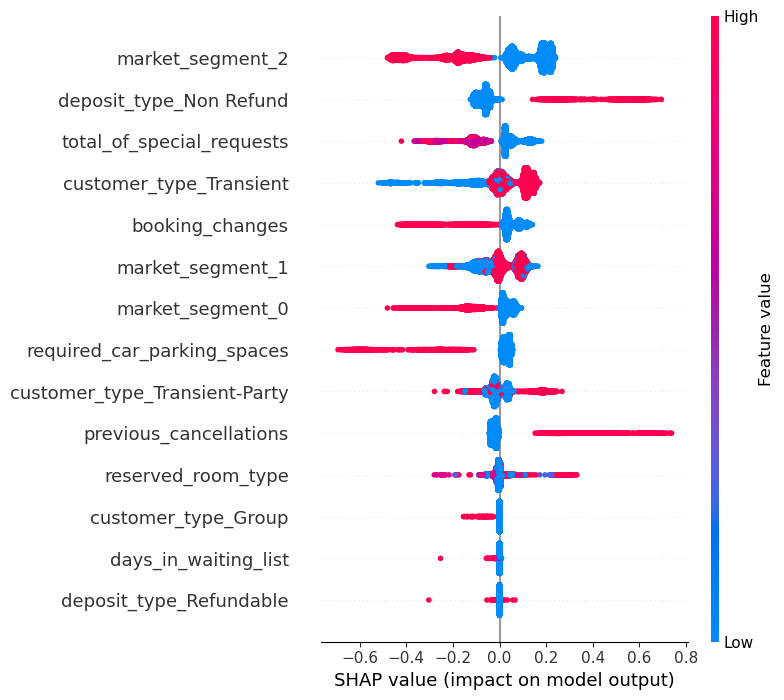

In [58]:
shap.summary_plot(shap_values, X_test_preprocessed)

<a id="Cost Analysis"></a>
# <p style="background-color:white; font-family:calibri; color:black; font-size:150%; text-align:left; border-radius:20px 50px;">Cost Analysis</p>

In [59]:
confusion_matrix(y_test, y_test_pred)

array([[4649, 5910],
       [ 393, 5763]], dtype=int64)

Let's define these variables:

- Price per night (P): $200
- Cost of FN: $250
- Cost of FP: $50

In [60]:
def compute_cost(num_fn, num_fp):
    cost_fn = 250
    cost_fp = 50
    cost = num_fn * cost_fn + num_fp * cost_fp
    return cost

In [61]:
# without machine learning
num_fn = 393 + 5763
num_fp = 0

cost_initial = compute_cost(num_fn, num_fp)
print("Cost without machine learning: $" + str(cost_initial))


# with machine learning
num_fn = 393
num_fp = 5910

cost_with_machine_learning = compute_cost(num_fn, num_fp)

print("Cost with machine learning: $" + str(cost_with_machine_learning))


print("Saving cost: $" + str(cost_initial - cost_with_machine_learning))

Cost without machine learning: $1539000
Cost with machine learning: $393750
Saving cost: $1145250


<a id="Conclusion"></a>
# <p style="background-color:white; font-family:calibri; color:black; font-size:150%; text-align:left; border-radius:20px 50px;">Conclusion</p>

from the hyperparameter tuning process, we decide that the best parameters for the benchmark is Random Forest model are as follows:

- n_estimators=125,
- min_samples_split=3,
- min_samples_leaf=2,
- max_depth=10,
- criterion="entropy",
- class_weight={0 : 1, 1: 3}
- Treshold = 0.39

The evaluation metrics score as follows:
- f2_score = 0.793
- recall score = 0.937

The Model help reduce the Financial risk due to Cost related to Cancellation about 74.4%. This helps stabilize the hotel financial balance.
With non refund as the critical parameter to predict the cancellation.  

## Further Analysis
The Author assume a lot of things in this case:
- Flat Price per Night, where price varies depend on season and type of reserved room. This should be tackle in the more depth analysis
- Impact of False Positives only $ 50 in numerical value. The author realize that this oversimplification forget many things and underestimate the effect of customer satisfaction, in the long run hotel reputation. however, this quality is hard to measure, that's why in further analysis should include this.
- Neglecting the Deposit, The company get the money due to deposit, it's also should be included when we calculate the cost of cancellation

## Recommendation

- Focus on Recall and F2 first, but later the hotel should focus on the F1
- Incentive for early cancellation